In [107]:
"""
データ取得
ChEMBLとBindingDBのデータを取得し、EC50の値を取得する
"""
import pandas as pd
import numpy as np

ChEMBL_df = pd.read_csv("./data/ChEMBL.tsv", sep='\t')
ChEMBL_df = ChEMBL_df.dropna(subset=['Standard Relation'])
ChEMBL_df = ChEMBL_df.dropna(subset=['Standard Value'])
ChEMBL_df = ChEMBL_df[ChEMBL_df['Standard Relation'].str.contains("'='")]
ChEMBL_df = ChEMBL_df[ChEMBL_df['Standard Units'].str.contains('nM')]

BindingDB_df = pd.read_csv("./data/BindingDB.tsv", sep='\t')
BindingDB_df = BindingDB_df.dropna(subset=['EC50 (nM)'])
BindingDB_df = BindingDB_df[~BindingDB_df['EC50 (nM)'].str.contains('<|>')]
BindingDB_df['EC50 (nM)'] = BindingDB_df['EC50 (nM)'].astype(float)

# 両データフレームを結合
ChEMBL_df = ChEMBL_df[['Smiles', 'Standard Value']]
ChEMBL_df = ChEMBL_df.rename(columns={'Standard Value': 'EC50 (nM)'})
BindingDB_df = BindingDB_df[['Ligand SMILES', 'EC50 (nM)']]
BindingDB_df = BindingDB_df.rename(columns={'Ligand SMILES': 'Smiles'})

df = pd.concat([ChEMBL_df, BindingDB_df])

# 重複を削除
df = df.drop_duplicates(subset='Smiles')
print(df['EC50 (nM)'].describe())

# 1000nM以下を1、それ以外を0に変換
df['EC50 (nM)'] = df['EC50 (nM)'].apply(lambda x: 1 if x <= 1000 else 0)
print(df['EC50 (nM)'].describe())

count    1.773000e+03
mean     4.483144e+03
std      4.856441e+04
min      0.000000e+00
25%      3.610000e+01
50%      2.330000e+02
75%      1.230000e+03
max      1.900000e+06
Name: EC50 (nM), dtype: float64
count    1773.000000
mean        0.731528
std         0.443289
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: EC50 (nM), dtype: float64


In [83]:
"""
データ前処理
- EC50は小さいほど強いので逆数を取り、標準化
"""

# EC50が1000以下のものを1, 1000以上のものを0にする
df['EC50 (nM)'] = df['EC50 (nM)'].apply(lambda x: 1 if x <= 1500 else 0)

print(df['EC50 (nM)'].describe())

# EC50の逆数を取り、標準化
# df['EC50 (nM)'] = 1 / df['EC50 (nM)']

# 標準化を行う場合
# from sklearn.preprocessing import StandardScaler
# df['EC50 (nM)'] = StandardScaler().fit_transform(df['EC50 (nM)'].values.reshape(-1, 1))

# min-max scalingを行う場合
# from sklearn.preprocessing import MinMaxScaler
# df['EC50 (nM)'] = df['EC50 (nM)'].astype(np.float32)
# df['EC50 (nM)'] = MinMaxScaler().fit_transform(df['EC50 (nM)'].values.reshape(-1, 1))

# print(df['EC50 (nM)'].describe())

count    1773.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: EC50 (nM), dtype: float64


In [108]:
"""
フィンガープリント作成
"""
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs import Sheridan

smiles_list = df['Smiles'].tolist()
# maccs = [AllChem.GetMACCSKeysFingerprint(Chem.MolFromSmiles(smiles)) for smiles in smiles_list]
# fp_df = pd.DataFrame(np.array(maccs, int))
ecfp = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 4, 4096) for smiles in smiles_list]
# fp_df = pd.concat([fp_df, pd.DataFrame(np.array(ecfp, int))], axis=1)
fp_df = pd.DataFrame(np.array(ecfp, int))

# 分散が0の変数を削除
fp_df = fp_df.loc[:, fp_df.var() != 0]

# 相関係数が高い変数を削除 -> 一つの構造による重複した寄与を削除
from dcekit.variable_selection import search_highly_correlated_variables
threshold_of_r = 0.5 #変数選択するときの相関係数の絶対値の閾値
corr_var = search_highly_correlated_variables(fp_df, threshold_of_r)
fp_df.drop(fp_df.columns[corr_var], axis=1, inplace=True)

# 5分子以上で出現するフィンガープリントのみを残す
fp_df = fp_df.loc[:, fp_df.sum() >= 5]

[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerator
[14:26:35] DEPRECATION WARNING: please use MorganGenerat

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [110]:
"""
学習
"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print(fp_df.shape)

X = fp_df
y = df['EC50 (nM)'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# borutaによる変数選択
from boruta import BorutaPy

corr_list = []
for n in range(10000):
    shadow_features = np.random.rand(X_train.shape[0]).T
    corr = np.corrcoef(X_train, shadow_features,rowvar=False)[-1]
    corr = abs(corr[corr < 0.95])
    corr_list.append(corr.max())
    corr_array = np.array(corr_list)
    perc = 100 * (1-corr_array.max())

rf = RandomForestRegressor(n_estimators=100, random_state=0)

feat_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=0,
    alpha=0.05,
    max_iter=50,
    perc=perc,
    random_state=0
)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

feat_selector.fit(X_train.values, y_train.values)

X_train_selected = X_train.iloc[:, feat_selector.support_]
X_test_selected = X_test.iloc[:, feat_selector.support_]

(1773, 1014)


In [111]:
# モデルの学習
rf.fit(X_train_selected, y_train)

# 2値分類の評価
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf.predict(X_test_selected)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.8450704225352113
[[ 67  32]
 [ 23 233]]
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71        99
         1.0       0.88      0.91      0.89       256

    accuracy                           0.85       355
   macro avg       0.81      0.79      0.80       355
weighted avg       0.84      0.85      0.84       355



In [112]:
"""
予測したい構造のフィンガープリントを作成
"""
from rdkit.Chem import AllChem

def generate_peptides(n):
    print("Generating peptides...")

    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    peptides = []

    def build_peptide(current_peptide):
        if len(current_peptide) == n:
            peptides.append(current_peptide)
            return
        for amino_acid in amino_acids:
            build_peptide(current_peptide + amino_acid)

    build_peptide('')

    print(f"Generated {len(peptides)} peptides.")
    
    return peptides

peptides = generate_peptides(3)
morgan_peptides = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromFASTA(peptide), 4, 4096) for peptide in peptides]
morgan_peptides_df = pd.DataFrame(np.array(morgan_peptides, int))

# fp_dfと同じ変数を持つようにする
morgan_peptides_df = morgan_peptides_df.loc[:, morgan_peptides_df.columns.isin(fp_df.columns)]

# モデルによる予測
morgan_peptides_df = morgan_peptides_df.iloc[:, feat_selector.support_]

result = rf.predict(morgan_peptides_df)
print(result)

Generating peptides...
Generated 8000 peptides.


[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerator
[15:27:22] DEPRECATION WARNING: please use MorganGenerat

[0.68067565 0.79882519 0.80592105 ... 0.63947368 0.61513158 0.68067565]


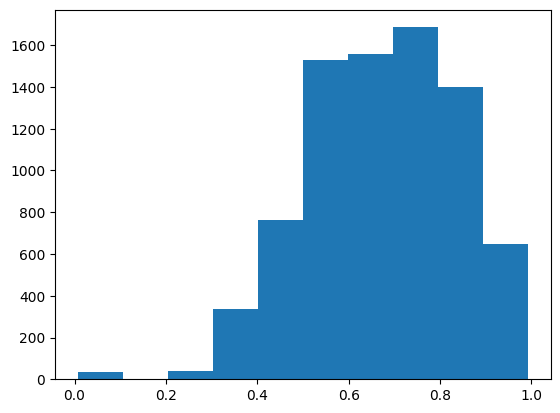

In [114]:
# resultを描画
import matplotlib.pyplot as plt

plt.hist(result)
plt.show()